In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from IPython.display import HTML
from celluloid import Camera

from thor_magni_tools.utils.load import load_csv_metadata_magni, preprocessing_header_magni
from thor_magni_tools.preprocessing.filtering import Filterer3DOF
from thor_magni_tools.preprocessing import TrajectoriesReprocessor
from thor_magni_tools.utils.visualization_nb import visualize_scenario

In [2]:
DIR_PATH = "../datasets/thor_magni_pub_ready/"
SCENARIO_ID = "Scenario_2"

In [3]:
raw_df, header_dict = load_csv_metadata_magni(
    os.path.join(DIR_PATH, SCENARIO_ID, "THOR-Magni_180522_SC2_R2.csv")
)

In [4]:
new_header_dict = preprocessing_header_magni(header_dict)
traj_metadata = new_header_dict["SENSOR_DATA"]["TRAJECTORIES"]["METADATA"]

### Filtering best markers

In [5]:
roles = {k: metadata["ROLE"] for k, metadata in traj_metadata.items()}
best_markers_traj = Filterer3DOF.filter_best_markers(raw_df, roles)

In [6]:
restored_markers = Filterer3DOF.restore_markers(raw_df, roles)

In [7]:
from thor_magni_tools.analysis.features import SpatioTemporalFeatures

In [8]:
best_markers_traj[["x", "y"]] /= 1000

In [9]:
trajectories = [best_markers_traj[best_markers_traj.ag_id == ag_id] for ag_id in best_markers_traj.ag_id.unique()]

In [10]:
speed_trajectories = SpatioTemporalFeatures.get_speed(trajectories)

In [11]:
import pandas as pd
speed_trajectories = pd.concat(speed_trajectories)

In [12]:
speed_trajectories = speed_trajectories.sort_index()

In [13]:
helmet_id = "Helmet_2"

In [14]:
speed_trajectories[speed_trajectories["ag_id"] == "Helmet_2"]

,frame_id,ag_id,x,y,z,data_label,best_marker_id,n_deltas,x_delta,y_delta,speed,x_speed,y_speed
Time,,,,,,,,,,,,,
0.01,2,Helmet_2,NaN,NaN,NaN,Carrier-Box,2,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
0.02,3,Helmet_2,8.661963,2.800402,1846.746,Carrier-Box,2,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
0.03,4,Helmet_2,8.658543,2.800729,1846.578,Carrier-Box,2,0.003436,-0.003420,0.000327,0.343560,-0.3420,0.0327
0.04,5,Helmet_2,8.657013,2.801782,1846.180,Carrier-Box,2,0.001857,-0.001530,0.001053,0.185734,-0.1530,0.1053
0.05,6,Helmet_2,8.656420,2.803545,1846.080,Carrier-Box,2,0.001860,-0.000593,0.001763,0.186006,-0.0593,0.1763
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238.98,23899,Helmet_2,7.610114,3.116239,1831.234,Carrier-Box,2,0.011963,0.010436,0.005849,1.196331,1.0436,0.5849
238.99,23900,Helmet_2,7.619564,3.121705,1832.025,Carrier-Box,2,0.010917,0.009450,0.005466,1.091694,0.9450,0.5466
239.00,23901,Helmet_2,7.630035,3.127770,1833.109,Carrier-Box,2,0.012101,0.010471,0.006065,1.210066,1.0471,0.6065


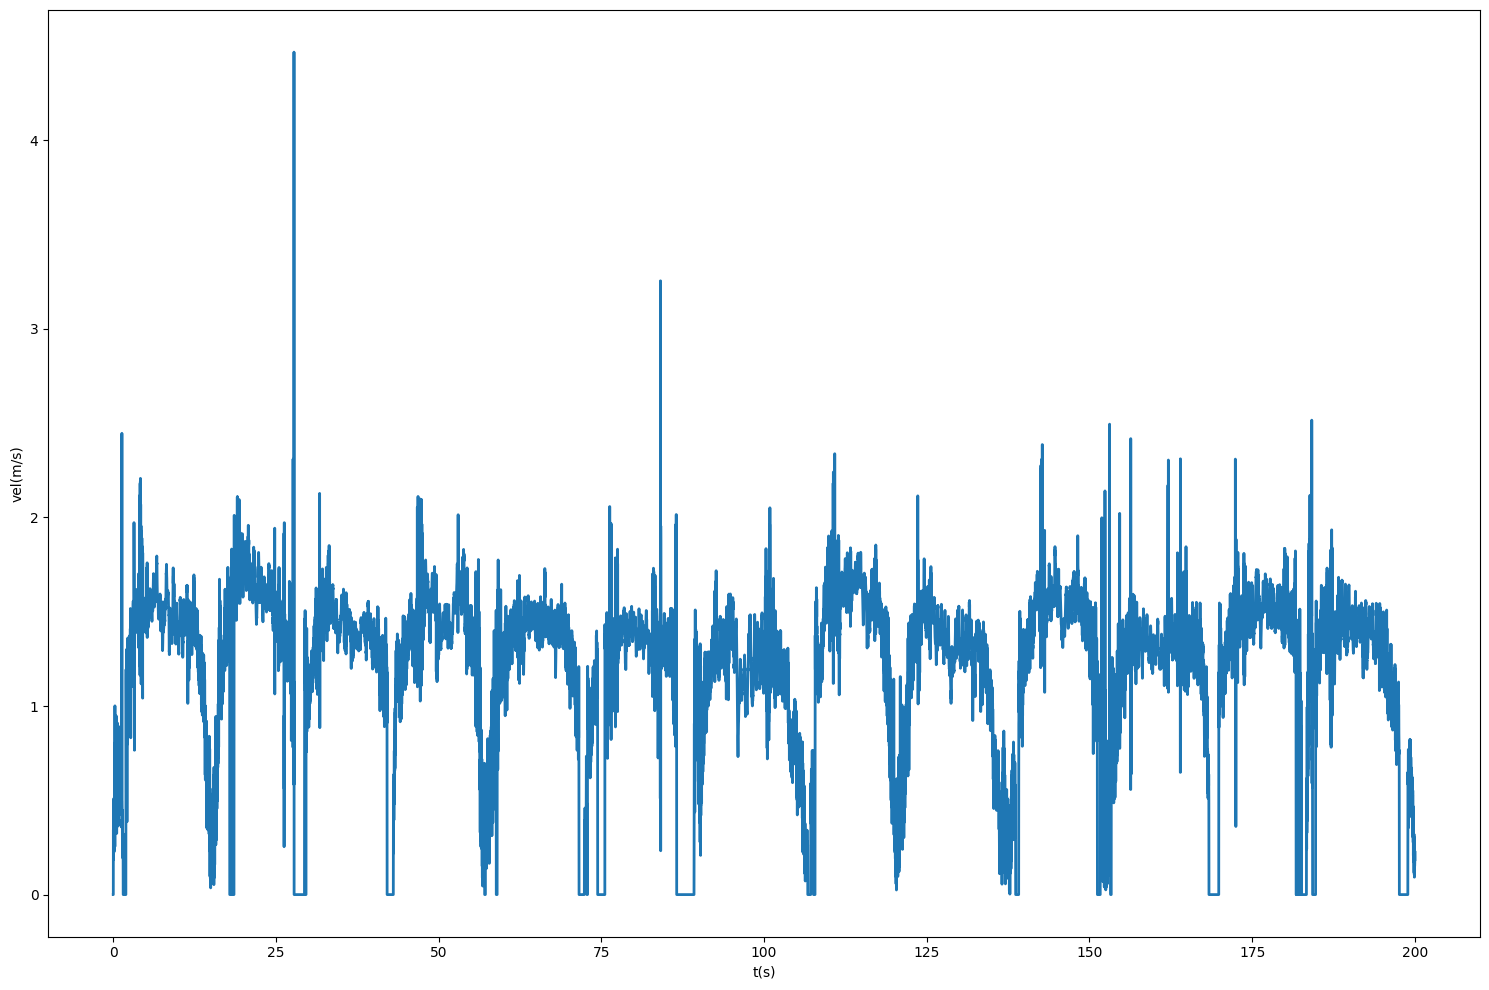

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(
    speed_trajectories[speed_trajectories.ag_id == helmet_id].index[:20000],
    speed_trajectories[speed_trajectories.ag_id == helmet_id].speed.iloc[:20000],
    linewidth=2,
)
plt.xlabel("t(s)")
plt.ylabel("vel(m/s)")
plt.tight_layout()

### Visualization

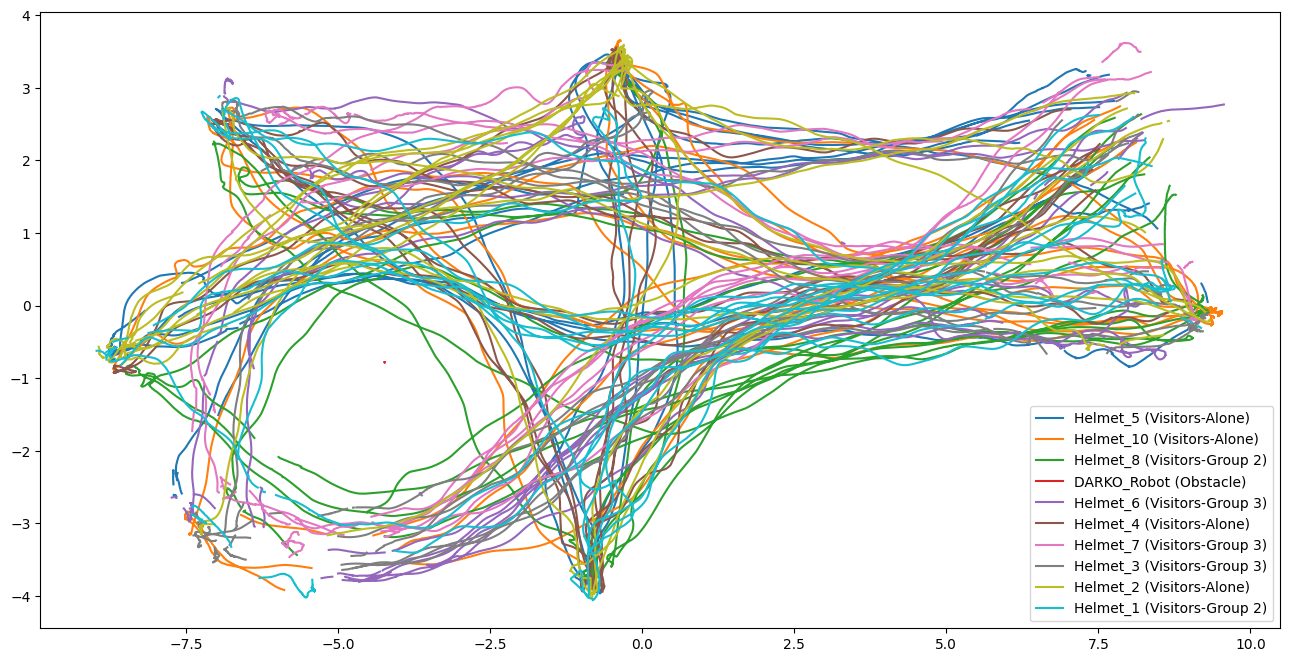

In [39]:
visualize_scenario(best_markers_traj, roles)

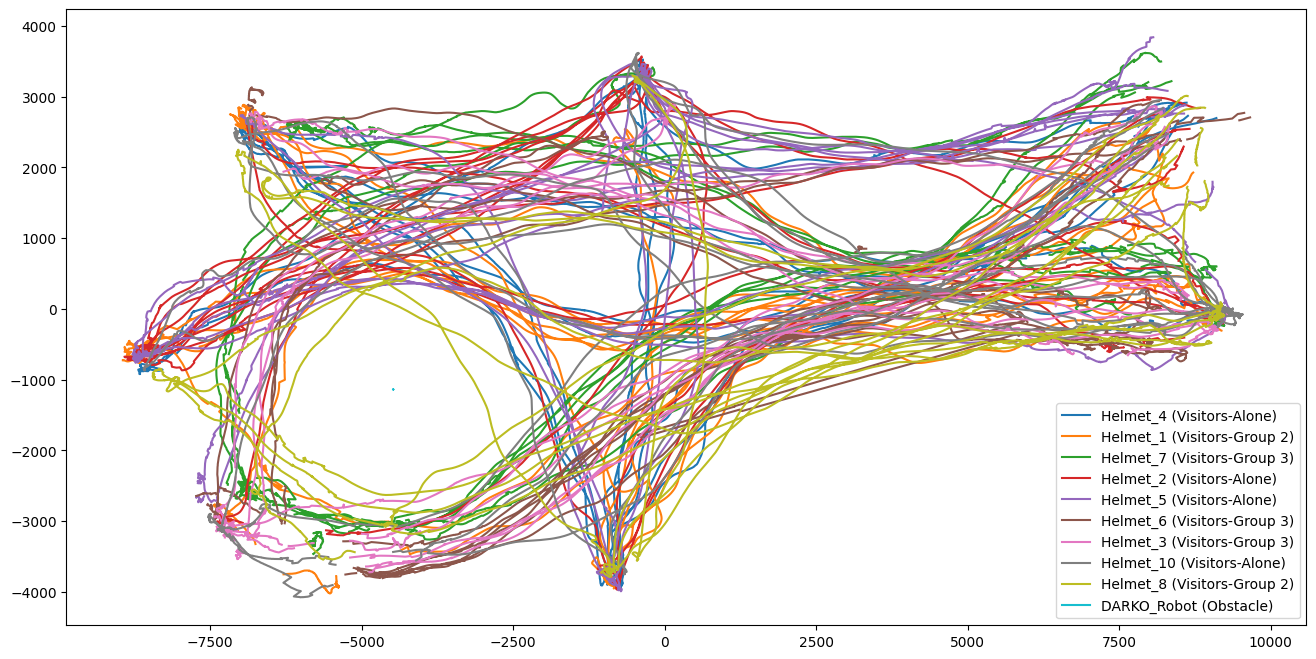

In [40]:
visualize_scenario(restored_markers, roles)

## Preprocessing

In [41]:
pp_best_markers = TrajectoriesReprocessor.reprocessing(
    best_markers_traj, 
    max_nans_interpolate=100, # max  1s interpolation
    resampling_rule="400ms",
    average_window="800ms",
)  

2023-12-06 17:45:31,102 - thor_magni_tools.preprocessing.reprocess - DEBUG - interpolation applied! (reprocess.py:61)
2023-12-06 17:45:31,107 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:73)
2023-12-06 17:45:31,112 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:88)


2023-12-06 17:45:31,143 - thor_magni_tools.preprocessing.reprocess - DEBUG - interpolation applied! (reprocess.py:61)
2023-12-06 17:45:31,150 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:73)
2023-12-06 17:45:31,154 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:88)
2023-12-06 17:45:31,190 - thor_magni_tools.preprocessing.reprocess - DEBUG - interpolation applied! (reprocess.py:61)
2023-12-06 17:45:31,199 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:73)
2023-12-06 17:45:31,206 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:88)
2023-12-06 17:45:31,237 - thor_magni_tools.preprocessing.reprocess - DEBUG - interpolation applied! (reprocess.py:61)
2023-12-06 17:45:31,244 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:73)
2023-12-06 17:45:31,247 - thor_magni_tools.preprocessing.reproc

In [42]:
pp_best_markers[pp_best_markers.ag_id == "Helmet_6"]

,frame_id,x,y,z,ag_id,data_label
Time,,,,,,
0.01,2,NaN,NaN,NaN,Helmet_6,Visitors-Group 3
0.41,42,NaN,NaN,NaN,Helmet_6,Visitors-Group 3
0.81,82,NaN,NaN,NaN,Helmet_6,Visitors-Group 3
1.21,122,NaN,NaN,NaN,Helmet_6,Visitors-Group 3
1.61,162,NaN,NaN,NaN,Helmet_6,Visitors-Group 3
...,...,...,...,...,...,...
241.21,24122,-6.838969,3.059103,1724.7055,Helmet_6,Visitors-Group 3
241.61,24162,-6.776826,3.089775,1742.1010,Helmet_6,Visitors-Group 3
242.01,24202,-6.733776,3.065278,1757.0520,Helmet_6,Visitors-Group 3


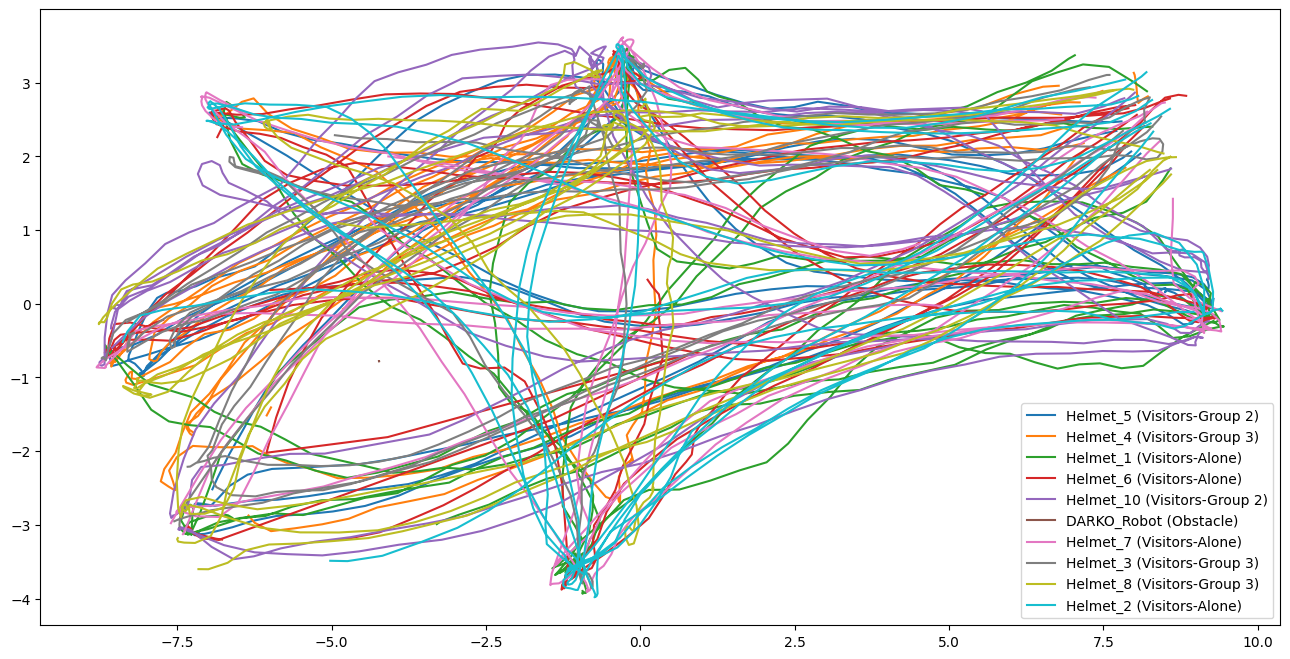

In [18]:
visualize_scenario(pp_best_markers, roles)

In [20]:
pp_best_markers[pp_best_markers.ag_id == "Helmet_6"].iloc[200:207]

,frame_id,x,y,z,ag_id,data_label
Time,,,,,,
80.01,8002,-7.281151,-3.052283,1627.963500,Helmet_6,Visitors-Alone
80.41,8042,-7.230963,-3.123997,1665.606000,Helmet_6,Visitors-Alone
80.81,8082,-7.107102,-3.182096,1698.228500,Helmet_6,Visitors-Alone
81.21,8122,-6.830877,-3.203922,1716.690000,Helmet_6,Visitors-Alone
81.61,8162,-1.472955,-1.587012,1711.268005,Helmet_6,Visitors-Alone
82.01,8202,0.837753,-0.672743,1691.790732,Helmet_6,Visitors-Alone
82.41,8242,-4.093665,-1.809288,1693.617227,Helmet_6,Visitors-Alone


In [11]:
pp_restored = TrajectoriesReprocessor.reprocessing(
    restored_markers, 
    max_nans_interpolate=100, # max  1s interpolation
    resampling_rule="400ms",
    average_window="800ms",
)  

2023-11-02 14:11:42,970 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:42,970 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:42,973 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:42,973 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:43,004 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:43,004 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:43,007 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:43,007 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:43,038 - thor_magni_tools.preprocessing

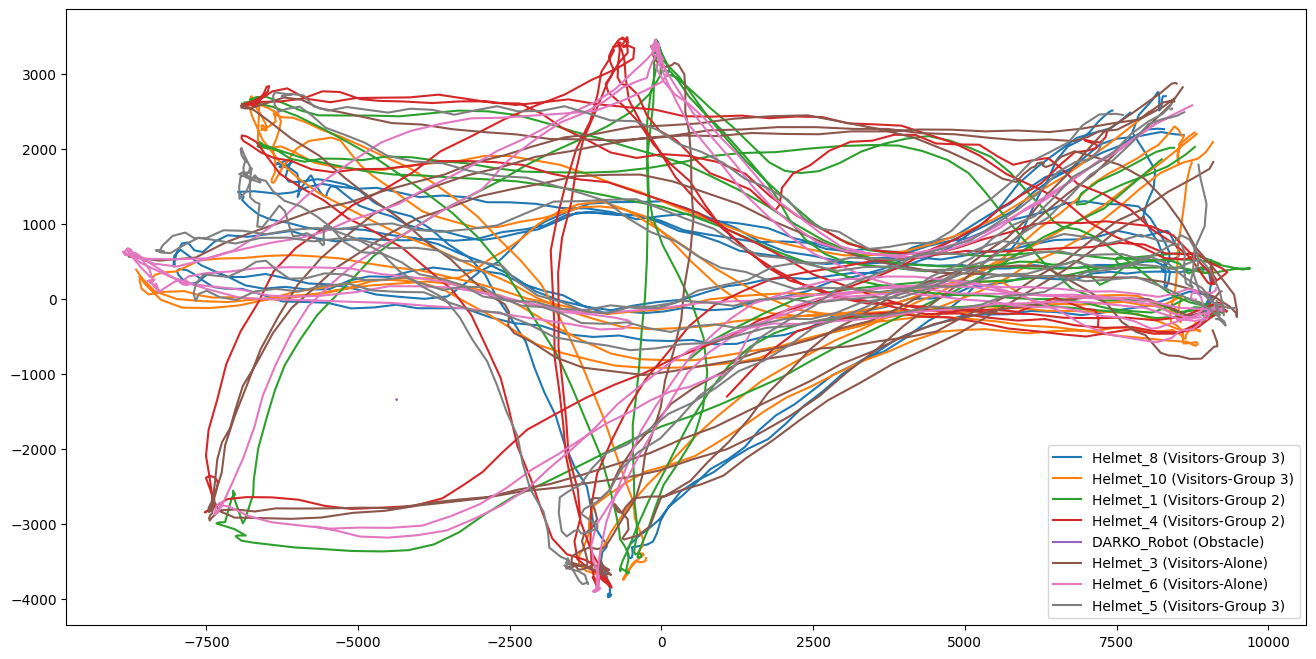

In [12]:
visualize_scenario(pp_restored, roles)

# Animation (take some time depedning on the number of frames)

In [9]:
cmap = get_cmap("tab20")
colors_agent = {
    body_name: cmap.colors[i] for i, body_name in enumerate(traj_metadata.keys())
}

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Y/mm", fontsize=29)
ax.set_xlabel("X/mm", fontsize=29)

camera = Camera(fig)

for frame in pp_restored.frame_id.iloc[:2000]:
    frame_data = pp_restored[pp_restored["frame_id"] == frame]
    agents_frame = frame_data.ag_id.unique()

    for agent in agents_frame:
        agent_data = frame_data[frame_data["ag_id"] == agent]
        agent_role = agent_data["data_label"].iloc[0]
        if not agent_data["x"].isna().all():
            plt.scatter(
                agent_data["x"],
                agent_data["y"],
                c=np.array([colors_agent[agent]]),
                s=70,
            )
            plt.text(
                agent_data["x"]-25,
                agent_data["y"]-50,
                agent.split("_")[-1],
                size="small",
                color="black",
                weight="semibold",
            )
    camera.snap()

# Stop the static plot from displaying
plt.close()

In [11]:
anim = camera.animate(interval = 10, repeat = True, repeat_delay = 500)
HTML(anim.to_html5_video())